# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях». 

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Бизнес-метрика и другие данные

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 
В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

Стоимость номеров отеля:
категория A: за ночь — 1 000, разовое обслуживание — 400;
категория B: за ночь — 800, разовое обслуживание — 350;
категория C: за ночь — 600, разовое обслуживание — 350;
категория D: за ночь — 550, разовое обслуживание — 150;
категория E: за ночь — 500, разовое обслуживание — 150;
категория F: за ночь — 450, разовое обслуживание — 150;
категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000.

При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.


Импортируем необходимые нам библиотеки и функции

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler
)
from sklearn.metrics import (
    recall_score, 
    f1_score,
    roc_auc_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier

!pip install scikit-learn==1.1.3

Объявляем постоянный переменные

In [2]:
BUDGET = 400000 # Бюджет на разработку системы
K1 = 1.4 # сезонный коэффициент летом
K2 = 1.2 # сезонный коэффициент весной и осенью
DEPOSIT_PROCENT = 0.8 # доля от стоимости номера для депозита
# стоимость номера за ночь в зависимости от категории
PRICE_A = 1000
PRICE_B = 800
PRICE_C = 600
PRICE_D = 550
PRICE_E = 500
PRICE_F = 450
PRICE_G = 350
# стоимость разового обслуживания в номере в зависимости от категории
CLEAN_A = 400
CLEAN_B = 350
CLEAN_C = 350
CLEAN_D = 150
CLEAN_E = 150
CLEAN_F = 150
CLEAN_G = 150

## Шаг 1. Откройте файлы с данными

### Напишем функцию для получения информации о датасете (вывод первых пяти срок, общей информации методом info(), описания информации в столбцах методом discribe(), построение гистограмм для визуализации распределения данных в столбцах), наличия явных дубликатов, построения матрицы корреляции с визуализацией в seaborn.¶

In [3]:
def get_info(data):
    display(data.head())
    display(data.info())
    display(data.describe())
    print('Количество явных дубликатов:', data.duplicated().sum())
    #display(data.corr())
    data.hist(figsize=(12, 12));
    fig, ax = plt.subplots(figsize=(12, 7))
    sns.heatmap(data.corr(), annot = True, fmt='.1g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm',  annot_kws={"fontsize":9})

### Cчитываем данные из файлов и сохраняем их в переменные df_train, df_test соответсвенно, получаем общую информацию о датафреймах с помощью функции get_info(data)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65229 entries, 0 to 65228
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              65229 non-null  int64  
 1   is_canceled                     65229 non-null  int64  
 2   lead_time                       65229 non-null  float64
 3   arrival_date_year               65229 non-null  int64  
 4   arrival_date_month              65229 non-null  object 
 5   arrival_date_week_number        65229 non-null  int64  
 6   arrival_date_day_of_month       65229 non-null  int64  
 7   stays_in_weekend_nights         65229 non-null  int64  
 8   stays_in_week_nights            65229 non-null  int64  
 9   adults                          65229 non-null  float64
 10  children                        65229 non-null  float64
 11  babies                          65229 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000,65229.000000
mean,43544.069172,0.368609,96.337917,2015.719021,31.339772,15.847813,0.825185,2.224793,1.836576,0.074890,0.007236,0.027151,0.128915,0.107713,0.194269,3.334422,0.056647,0.512763,3.049978
std,25614.858971,0.482431,96.127545,0.449481,13.464024,8.748182,0.853477,1.354992,0.480245,0.334243,0.098790,0.162523,0.965326,1.326638,0.593838,18.239606,0.232094,0.752590,1.738108
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,19108.000000,0.000000,17.000000,2015.000000,21.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,40554.000000,0.000000,64.000000,2016.000000,34.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,67414.000000,1.000000,151.000000,2016.000000,42.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,84121.000000,1.000000,374.000000,2016.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,58.000000,17.000000,259.000000,3.000000,5.000000,10.000000


Количество явных дубликатов: 0


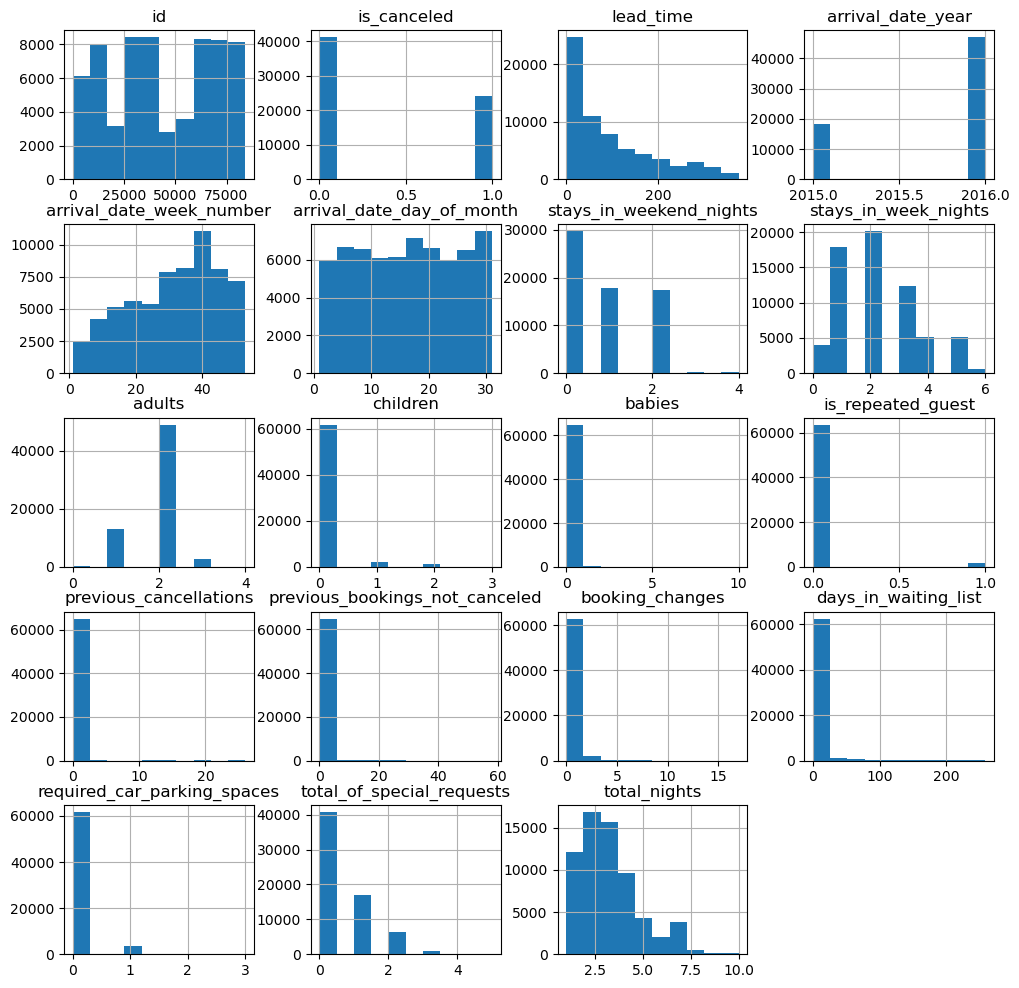

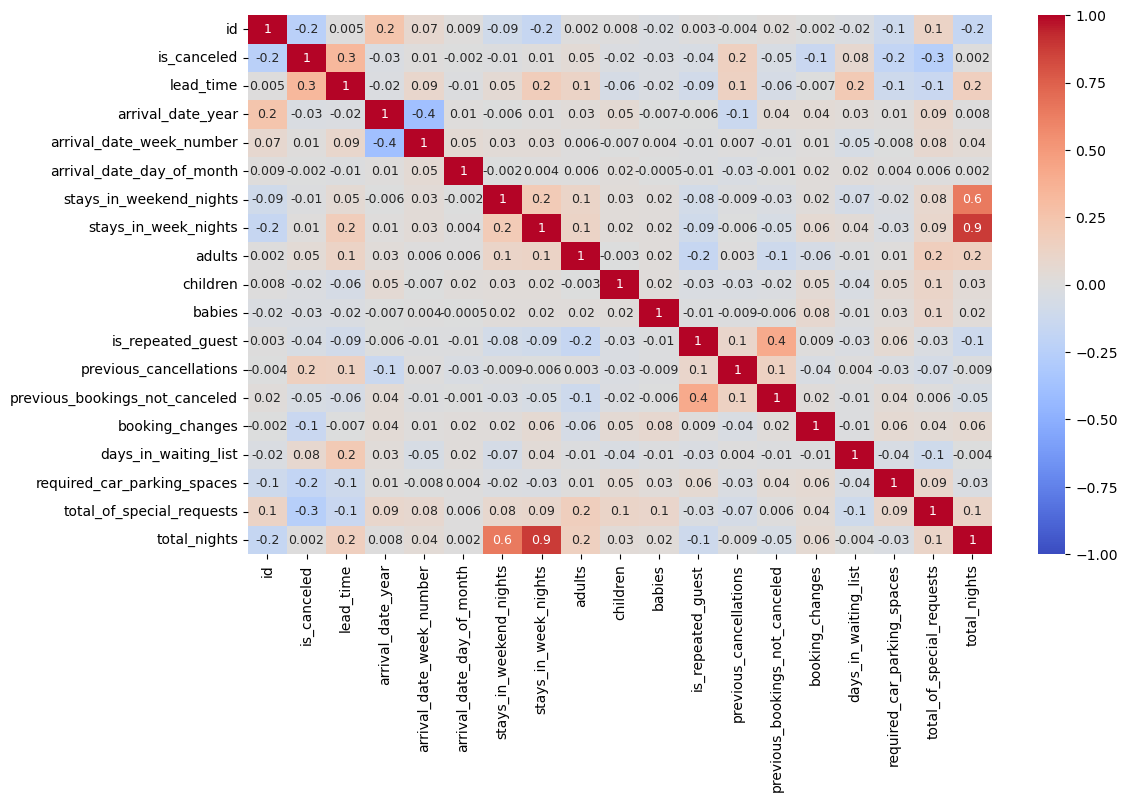

In [4]:
#df_train = pd.read_csv('/datasets/hotel_train.csv')
df_train = pd.read_csv('D:\Мои Документы\Desktop\Материалы по учебе\Сборный проект 2\hotel_train.csv')
get_info(df_train)

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32412 entries, 0 to 32411
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              32412 non-null  int64  
 1   is_canceled                     32412 non-null  int64  
 2   lead_time                       32412 non-null  float64
 3   arrival_date_year               32412 non-null  int64  
 4   arrival_date_month              32412 non-null  object 
 5   arrival_date_week_number        32412 non-null  int64  
 6   arrival_date_day_of_month       32412 non-null  int64  
 7   stays_in_weekend_nights         32412 non-null  int64  
 8   stays_in_week_nights            32412 non-null  int64  
 9   adults                          32412 non-null  float64
 10  children                        32412 non-null  float64
 11  babies                          32412 non-null  float64
 12  meal                            

None

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,32412.000000,32412.000000,32412.000000,32412.0,32412.000000,32412.000000,32412.000000,32412.00000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000,32412.000000
mean,60131.505183,0.388467,97.587869,2017.0,17.804054,15.656948,0.867888,2.34009,1.858602,0.083765,0.005523,0.031377,0.011601,0.171418,0.216741,0.262341,0.046248,0.657781,3.207979
std,29953.586177,0.487409,86.507146,0.0,9.177384,8.766429,0.853394,1.37517,0.489341,0.343470,0.075757,0.174338,0.180473,1.875170,0.640551,4.733027,0.219367,0.834341,1.738683
min,6086.000000,0.000000,0.000000,2017.0,1.000000,1.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,45291.750000,0.000000,23.000000,2017.0,10.000000,8.000000,0.000000,1.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,53394.500000,0.000000,76.000000,2017.0,18.000000,15.500000,1.000000,2.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,89800.250000,1.000000,155.000000,2017.0,25.000000,23.000000,2.000000,3.00000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,373.000000,2017.0,35.000000,31.000000,4.000000,6.00000,4.000000,3.000000,2.000000,1.000000,6.000000,72.000000,18.000000,223.000000,8.000000,5.000000,10.000000


Количество явных дубликатов: 0


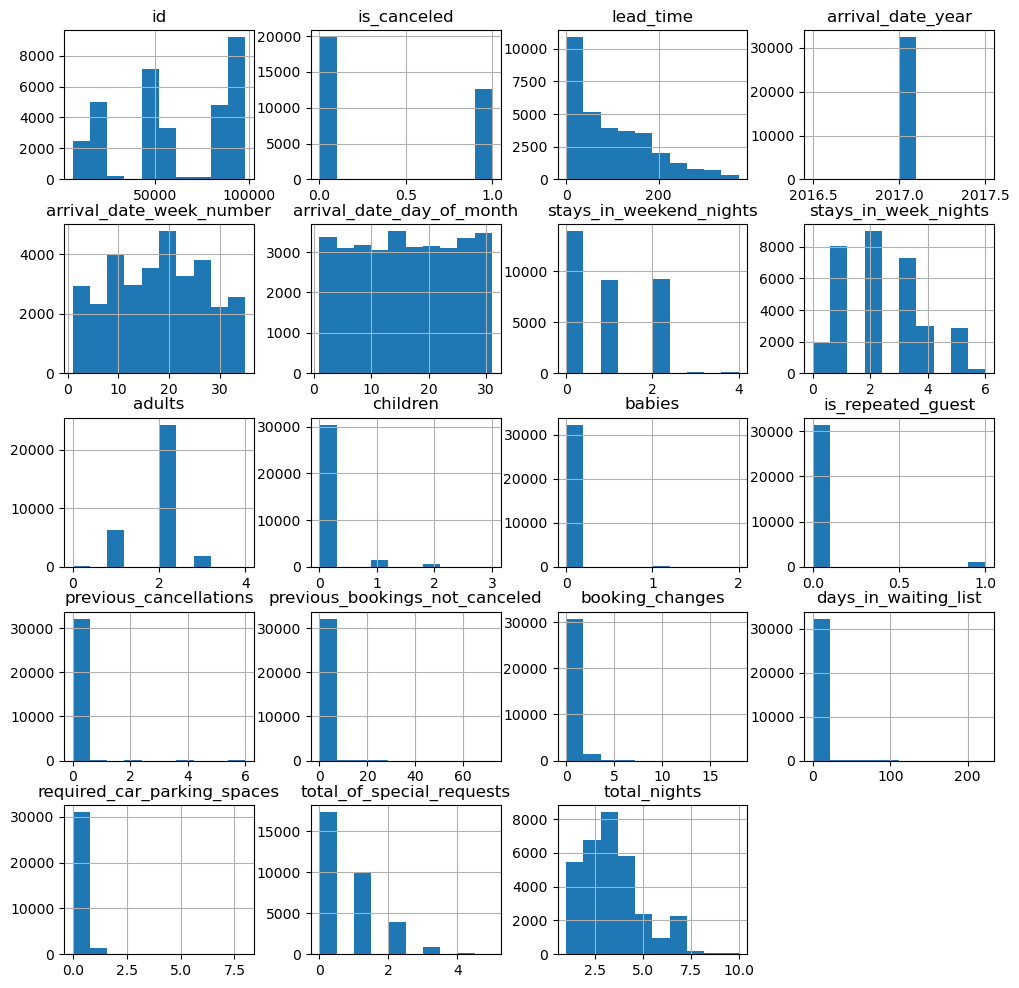

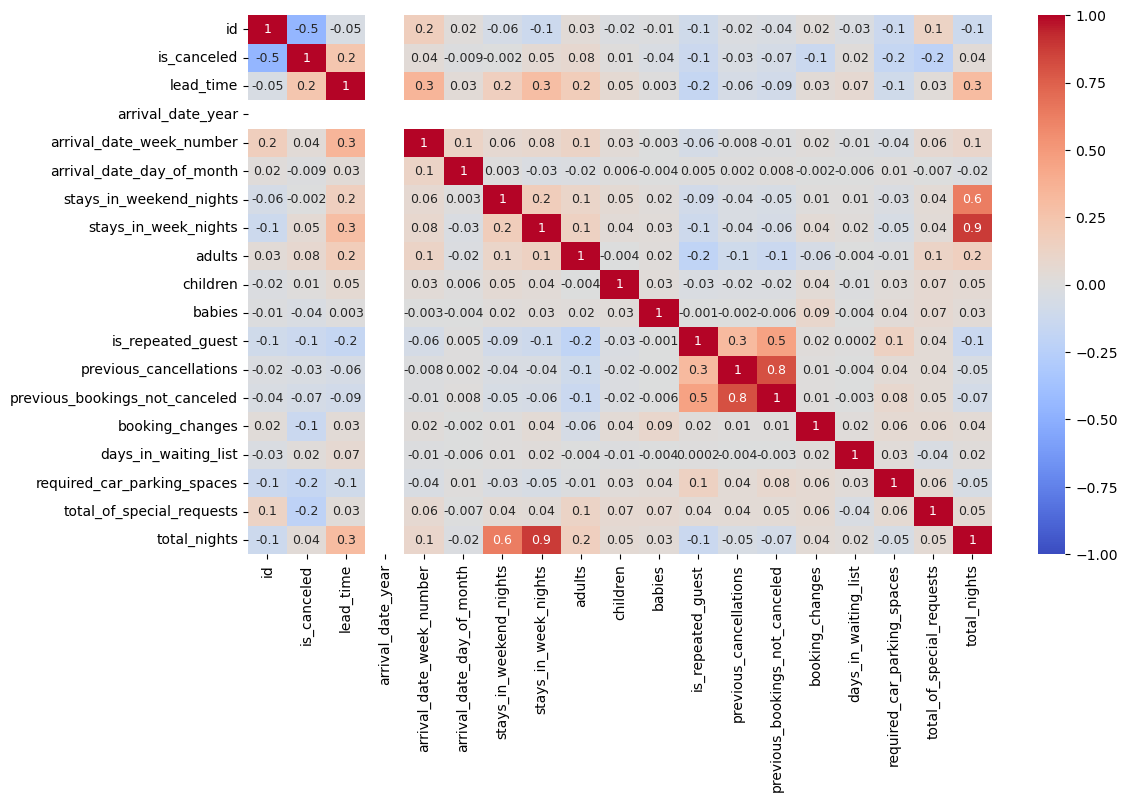

In [5]:
#df_test = pd.read_csv('/datasets/hotel_test.csv')
df_test = pd.read_csv('D:\Мои Документы\Desktop\Материалы по учебе\Сборный проект 2\hotel_test.csv')
get_info(df_test)

#### Открыв файл и ознакомившись с общей информацией по датафреймам можно сделать следующие выводы: 
- в таблицах df_train и df_test одиникавые количество и название столбцов;
- пропусков в данных нет;
- явных дубликатов нет;
- отказов от брони достаточно много (больше половины тех, кто в итоге воспользовался услугами отеля). Так как это целевой признак надо отметить наличие дисбаланса классов, который надо учесть при обучении моделей;
- прослеживается зависимость между количеством подтверждённых заказов и повторным бронированием. Также есть коллинеарные признаки total_nights и stays_in_weekend_nights и stays_in_week_nights. При обучении модели необходимо это учесть.
- в целом распределения данных выглядит вполне логично, но есть вопросы по некоторым столбцам, которые надо изучить более подробно на предмет анамалий и выбрасов 
- надо также проверить данные на наличие неявных дубликатов в категориальных переменных
- перевести данные в столбцах lead_time, adults, children, babies в int, т.к. тут все числа целые   

## Шаг 2. Предобработка и исследовательский анализ данных

### Удаляем столбец с id  в обоих таблицах, т.к. он не несет полезной информации для обучения

In [6]:
df_train = df_train.drop(['id'], axis=1)
df_test = df_test.drop(['id'], axis=1)

### Проверим еще раз данные на дубликаты, т.к. удаление id могло привести к их появлению

In [7]:
print('Количество явных дубликатов в обучающем датафрейме:', df_train.duplicated().sum())
print('Количество явных дубликатов в тестовом датафрейме:', df_test.duplicated().sum())

Количество явных дубликатов в обучающем датафрейме: 21377
Количество явных дубликатов в тестовом датафрейме: 7717


#### Выявлено большое количество дубликатов. С чем это связано сказать трудно, поэтому их удаляем

In [8]:
df_train = df_train.drop_duplicates().reset_index(drop=True)
df_test = df_test.drop_duplicates().reset_index(drop=True)
print(len(df_train))
len(df_test)

43852


24695

### С помощью метода astype() изменим тип данных в столбцах lead_time, adults, children, babies в обоих датафреймах на int

In [9]:
df_train[['lead_time', 'adults', 'children', 'babies']] = df_train[['lead_time', 'adults', 
                                                                  'children', 'babies']].astype('int64')

In [10]:
df_test[['lead_time', 'adults', 'children', 'babies']] = df_test[['lead_time', 'adults', 
                                                                  'children', 'babies']].astype('int64')

### Проверяем уникальные значения в столбцах  arrival_date_month, country, meal, distribution_channel, reserved_room_type, customer_type  обоих датафреймов. Для этого сначала напишем функцию. Затем  сначала исследуем данные в df_train, а затем в df_test

In [11]:
def unique_data(data):
    display(data['arrival_date_month'].unique())
    print(data['country'].unique())
    display(data['meal'].unique())
    display(data['distribution_channel'].unique())
    display(data['reserved_room_type'].unique())
    display(data['customer_type'].unique())

In [12]:
unique_data(df_train)

array(['July', 'August', 'September', 'October', 'November', 'December',
       'January', 'February', 'March', 'April', 'May', 'June'],
      dtype=object)

['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'SYC' 'PRY' 'BRB'
 'ABW' 'SLV' 'DMA' 'CUB' 'PYF' 'UGA' 'GUY' 'LCA' 'ATA' 'RWA' 'MNE']


array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

array(['Direct', 'TA/TO', 'Corporate', 'GDS'], dtype=object)

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

array(['Transient', 'Contract', 'Transient-Party', 'Group'], dtype=object)

#### В столбцах meal и  reserved_room_type есть лишние пробелы, которые в том числе приводять к возникновению неявных дубликатов, удаляем их с помощью str.strip() и проверяем.

In [13]:
df_train['meal'] = df_train['meal'].str.strip()
df_train['meal'].unique()

array(['BB', 'FB', 'HB', 'SC'], dtype=object)

In [14]:
df_train['reserved_room_type'] = df_train['reserved_room_type'].str.strip()
df_train['reserved_room_type'].unique()

array(['A', 'C', 'D', 'E', 'G', 'F', 'B'], dtype=object)

In [15]:
unique_data(df_test)

array(['January', 'February', 'March', 'April', 'May', 'June', 'July',
       'August'], dtype=object)

['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' 'FRA' 'ITA' 'LUX' 'CHE' 'EST'
 'NGA' 'IRL' 'CN' 'POL' 'AUS' 'NLD' 'KOR' 'ROU' 'USA' 'CHL' 'DNK' 'FIN'
 'RUS' 'SWE' 'HUN' 'HRV' 'MDV' 'ZAF' 'ISR' 'NOR' 'CHN' 'ARE' 'MAR' 'COL'
 'FJI' 'LVA' 'LBN' 'PHL' 'HKG' 'SYC' 'GIB' 'AGO' 'MYS' 'MDG' 'IDN' 'LTU'
 'ISL' 'TUR' 'ARG' 'JPN' 'SVN' 'SVK' 'BGR' 'CAF' 'JAM' 'UZB' 'UKR' 'IND'
 'CZE' 'URY' 'NZL' 'NPL' 'SRB' 'CPV' 'IRN' 'KAZ' 'BHS' 'SUR' 'CUB' 'PAK'
 'MAC' 'CYP' 'JOR' 'GRC' 'KWT' 'TWN' 'VNM' 'SGP' 'DOM' 'VEN' 'SEN' 'BLR'
 'TZA' 'LIE' 'GNB' 'SAU' 'DZA' 'PER' 'AZE' 'EGY' 'ETH' 'KEN' 'THA' 'MLT'
 'ECU' 'AND' 'IMN' 'BHR' 'TUN' 'MNE' 'MEX' 'BEN' 'MOZ' 'UMI' 'JEY' 'MYT'
 'QAT' 'BGD' 'GAB' 'CIV' 'ZWE' 'GTM' 'ALB' 'GHA' 'ATA' 'ASM' 'PAN' 'CRI'
 'MCO' 'MUS' 'SYR' 'TGO' 'IRQ' 'LKA' 'BIH' 'PRY' 'MRT' 'ABW' 'NCL' 'STP'
 'KIR' 'SDN' 'PRI' 'ATF' 'CMR' 'TJK' 'LBY' 'SLE' 'SLV' 'LAO' 'FRO']


array(['BB       ', 'HB       ', 'SC', 'FB       ', 'SC       '],
      dtype=object)

array(['TA/TO', 'Direct', 'Corporate', 'GDS'], dtype=object)

array(['A               ', 'E               ', 'G               ',
       'D               ', 'F               ', 'C               ',
       'B               '], dtype=object)

array(['Transient', 'Transient-Party', 'Contract', 'Group'], dtype=object)

#### Вывод - здесь аналогиная ситуация. В столбцах meal и  reserved_room_type есть лишние пробелы, которые в том числе приводять к возникновению неявных дубликатов, удаляем их с помощью str.strip() и проверяем. Также важно отметить \, чо данные в df_test представлены только за 8 месяцев 2017 года.

In [16]:
df_test['meal'] = df_test['meal'].str.strip()
df_test['meal'].unique()

array(['BB', 'HB', 'SC', 'FB'], dtype=object)

In [17]:
df_test['reserved_room_type'] = df_test['reserved_room_type'].str.strip()
df_test['reserved_room_type'].unique()

array(['A', 'E', 'G', 'D', 'F', 'C', 'B'], dtype=object)

### Исследуем данные в столбце adults в обоих датафреймах, т.к min значение в данном столбце 0, что вызывает вопросы. Посмотри сколько таких номеров и проверим, есть ли в них дети (children). Номера, в которых не проживают взрослые удаляем

In [18]:
print(len(df_train.query('adults == 0')))
df_train.query('adults == 0')['children'].value_counts()

164


2    139
0     15
3      8
1      2
Name: children, dtype: int64

#### Номера, в которых не проживают взрослые удаляем.

In [19]:
df_train = df_train.query('adults != 0')
len(df_train)

43688

#### Аналогичное исследование проводим в отношении df_test

In [20]:
print(len(df_test.query('adults == 0')))
df_test.query('adults == 0')['children'].value_counts()

65


2    54
0     7
1     2
3     2
Name: children, dtype: int64

In [21]:
df_test = df_test.query('(adults != 0) or (adults == 0 and children!=0)')
len(df_test)

24688

### Исследуем данные в столбце babies датафрейма df_train, т.к тут максимальное значение 10, что скорре всего является ошибкой. Аналогичной проверки в датафрейме df_test не делаем, т.к. там максимальное значение 2, что вполне может быть.

In [22]:
display(df_train.query('babies > 4'))
df_train.query('babies > 4')['babies']

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
16298,0,37,2016,January,3,12,0,2,2,0,...,0,0,0,D,1,0,Transient,0,1,2
25718,0,11,2015,October,42,11,2,1,1,0,...,0,0,0,A,1,0,Transient-Party,0,0,3


16298    10
25718     9
Name: babies, dtype: int64

#### Эти данные удаляем, скорее всего здесь ошибка при внесении данных. Лучше их удалить.

In [23]:
df_train = df_train.query('babies <= 4')
df_train.shape[0]

43686

In [24]:
df_train['babies'].value_counts()

0    43242
1      441
2        3
Name: babies, dtype: int64

#### Так как постояльцев с числом младенцев 2 только 3, изменим эти значения на 1, чтобы у нас было только два значения 0- нет младенцев, 1 - есть младенцы. Аналогично поступим и в df_test

In [25]:
df_train.loc[df_train['babies'] > 1, 'babies'] = 1
df_train['babies'].unique()

array([0, 1], dtype=int64)

In [26]:
df_test.loc[df_test['babies'] > 1, 'babies'] = 1
df_test['babies'].unique()

array([0, 1], dtype=int64)

### Проверим нет ли случае, когда  сумма ночей в будние дни и выходные не совпадаем с общим количеством ночей 

In [27]:
df_train.query('(stays_in_weekend_nights + stays_in_week_nights ) != total_nights')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


In [28]:
df_test.query('(stays_in_weekend_nights + stays_in_week_nights ) != total_nights')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights


#### Таких случаев нет, тут с данными все хорошо. Но признаки total_nights и stays_in_weekend_nights  и stays_in_week_nights коллинеарные. Соответсвенно надо удалить столбец  total_nights в дальнейшем при обучении.

###  Исследуем данные в столбцах required_car_parking_spaces, нам интересны случаи, когда гости отеля запрашивают больше одного парковочного места.

In [29]:
df_train.query('required_car_parking_spaces > 1')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
1433,0,122,2015,October,43,22,1,3,2,0,...,0,0,0,D,0,0,Transient,2,2,4
2816,0,225,2016,May,22,26,2,3,2,0,...,0,0,0,A,2,0,Transient-Party,2,0,5
5284,0,199,2015,September,36,3,0,3,1,0,...,0,0,0,D,0,0,Transient-Party,2,2,3
8298,0,36,2016,March,11,10,2,5,2,0,...,0,0,0,A,0,0,Transient,2,2,7
8672,0,0,2016,March,14,27,2,1,2,0,...,0,0,0,E,0,0,Transient,2,1,3
8747,0,169,2016,March,14,31,1,3,2,0,...,0,0,0,A,0,0,Transient-Party,2,0,4
9344,0,3,2016,April,18,30,1,1,2,0,...,0,0,0,D,0,0,Transient,2,0,2
9877,0,223,2016,May,22,24,1,5,2,0,...,0,0,0,A,4,0,Transient-Party,2,0,6
10849,0,180,2016,August,32,1,1,4,2,1,...,0,0,0,A,3,0,Transient,2,3,5
11253,0,139,2016,September,37,5,1,5,2,0,...,0,0,0,A,0,0,Transient-Party,2,1,6


#### Тут скорее всего ошибки в данных, т.к. вряд ли одному человеку понадобится 3 или 2 парковочных места, но скорее всего парковочное место нужно. Так как вариантов, что запрашивают более 1 парковочного места мало, предлагаю все свести к двум категориям: 0 - не нужно парковочное место и 1 - нужно парковочное место.

In [30]:
df_train.loc[df_train['required_car_parking_spaces'] > 1, 'required_car_parking_spaces'] = 1
df_train['required_car_parking_spaces'].unique()

array([0, 1], dtype=int64)

In [31]:
df_test.query('required_car_parking_spaces > 1')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
2060,0,5,2017,March,10,10,0,2,2,1,...,1,0,0,G,1,0,Transient,2,2,2
2107,0,26,2017,March,11,14,0,5,2,0,...,1,0,2,E,1,0,Transient-Party,8,1,5
2108,0,138,2017,March,12,19,2,2,2,0,...,1,0,2,E,1,122,Transient-Party,8,0,4
2358,0,7,2017,January,2,11,0,2,2,0,...,0,0,0,A,0,0,Transient,2,1,2
2696,0,0,2017,January,4,27,0,2,2,2,...,0,0,0,G,0,0,Transient-Party,2,0,2
2697,0,0,2017,January,5,29,1,0,2,2,...,1,0,0,G,0,0,Transient-Party,2,0,1
2723,0,43,2017,January,4,27,1,2,2,0,...,0,0,0,A,0,0,Transient-Party,2,1,3
3524,0,5,2017,February,9,28,1,5,2,0,...,0,0,0,A,1,0,Transient-Party,2,0,6
18368,0,30,2017,April,17,29,2,1,2,0,...,0,0,0,A,0,0,Transient-Party,3,2,3


#### Тут аналогичная ситуация, поступаем также

In [32]:
df_test.loc[df_test['required_car_parking_spaces'] > 1, 'required_car_parking_spaces'] = 1
df_test['required_car_parking_spaces'].unique()

array([0, 1], dtype=int64)

### Исследуем данные в столбце lead_time обоих датафреймов. Построим еще раз гистограмму для данного столбца, т.к. часть данных была удалена, и посчитаем 99 квантиль, т.к ранее наблюдался длинный хвост справа.

<AxesSubplot:title={'center':'Количество дней между датой бронирования и датой прибытия'}, ylabel='Frequency'>

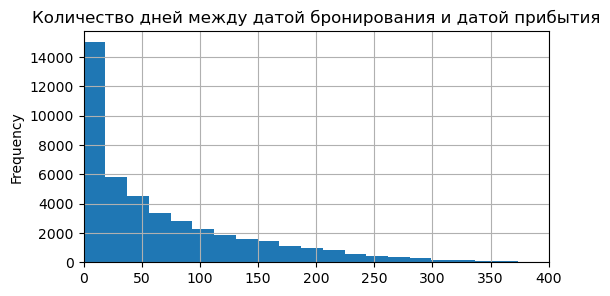

In [33]:
df_train['lead_time'].plot(kind='hist', bins=20, title ='Количество дней между датой бронирования и датой прибытия', 
                           figsize = (6,3), grid=True, xlim=(0,400))

In [34]:
df_train['lead_time'].quantile(q=0.99)

305.0

In [35]:
print(len(df_train.query('lead_time > 305')))
df_train.query('lead_time >305')['is_canceled'].value_counts()

430


0    244
1    186
Name: is_canceled, dtype: int64

#### Эти данные попадают в зону выбросов, их лучше удалить. Хотя конечно есть люди, которые бронируют гостиницы за год и ранее, и в целом такое раннее бронирование корелируется с большим количеством отказов.

In [36]:
df_train = df_train.query('lead_time <= 305')
len(df_train)


43256

<AxesSubplot:title={'center':'Количество дней между датой бронирования и датой прибытия'}, ylabel='Frequency'>

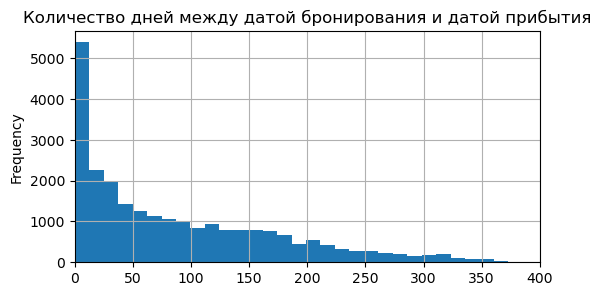

In [37]:
df_test['lead_time'].plot(kind='hist', bins=30, title ='Количество дней между датой бронирования и датой прибытия', figsize = (6,3), grid=True, xlim=(0,400))

In [38]:
df_test['lead_time'].quantile(q=0.99)

330.0

In [39]:
print(len(df_test.query('lead_time > 330')))
df_test.query('lead_time > 330')['is_canceled'].value_counts()

241


1    147
0     94
Name: is_canceled, dtype: int64

####  Эти данные попадают в зону выбросов, их лучше удалить

In [40]:
df_test = df_test.query('lead_time <= 330')
len(df_test)

24447

### Исследуем данные в столбце previous_cancellations, здесь наблюдются отдельные значения, которые отличаются от медианного и среднего значения, которые находяться в районе 0. 

In [41]:
df_train['previous_cancellations'].value_counts()

0     42188
1       916
2        48
3        47
11       27
5        13
4         5
13        3
24        2
6         2
26        1
25        1
14        1
19        1
21        1
Name: previous_cancellations, dtype: int64

In [42]:
df_train.query('previous_cancellations > 5')['is_canceled'].value_counts()

0    26
1    13
Name: is_canceled, dtype: int64

#### Отбросим значения previous_cancellations > 5, далее значения идут неравномерно и их мало

In [43]:
df_train = df_train.query('previous_cancellations <= 5')
df_train['previous_cancellations'].value_counts()

0    42188
1      916
2       48
3       47
5       13
4        5
Name: previous_cancellations, dtype: int64

In [44]:
df_test['previous_cancellations'].value_counts()

0    24226
1      160
2       29
6       15
4       10
3        6
5        1
Name: previous_cancellations, dtype: int64

#### Тут отсавим все

### Исследуем данные в столбце previous_cancellations, здесь наблюдются отдельные значения, которые отличаются от медианного и среднего значения, которые находяться в районе 0.¶

<AxesSubplot:title={'center':'количество подтвержденных заказов у клиента'}, ylabel='Frequency'>

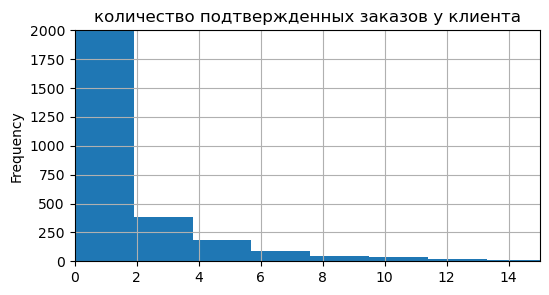

In [45]:
df_train['previous_bookings_not_canceled'].plot(kind='hist', bins=30, title ='количество подтвержденных заказов у клиента', 
                           figsize = (6,3), grid=True, ylim=(0,2000), xlim=(0,15))

#### Отбрасываем значения больше 15 

In [46]:
df_train = df_train.query('previous_bookings_not_canceled <= 15')

<AxesSubplot:title={'center':'количество подтвержденных заказов у клиента'}, ylabel='Frequency'>

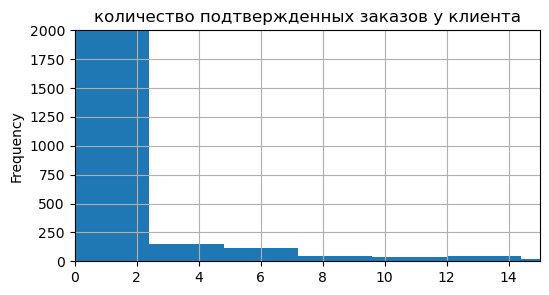

In [47]:
df_test['previous_bookings_not_canceled'].plot(kind='hist', bins=30, title ='количество подтвержденных заказов у клиента', 
                           figsize = (6,3), grid=True, ylim=(0,2000), xlim=(0,15))

#### Поступаем аналогичным образом

In [48]:
df_test = df_test.query('previous_bookings_not_canceled <= 15')

### Исследуем данные в столбце booking_changes 

In [49]:
df_train['booking_changes'].value_counts()

0     35796
1      5234
2      1525
3       352
4       136
5        38
6        17
7        17
8         7
9         5
13        4
10        2
14        2
15        2
16        1
17        1
Name: booking_changes, dtype: int64

#### Отбрасываем данные больше 10, т.к. дальше значений мало.

In [50]:
df_train = df_train.query('booking_changes <= 10')

In [51]:
df_test['booking_changes'].value_counts()

0     20364
1      2549
2      1055
3       250
4       107
5        27
6        13
7         5
18        1
15        1
16        1
14        1
8         1
11        1
10        1
Name: booking_changes, dtype: int64

#### Отбрасываем данные больше 7, т.к. дальше значений мало.

In [52]:
df_test = df_test.query('booking_changes <= 7')

### Исследуем данные в столбце days_in_waiting_list

In [53]:
df_train.query('days_in_waiting_list > 200')

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
18043,1,268,2016,April,15,8,2,3,2,0,...,0,0,0,A,0,224,Transient-Party,0,0,5
18045,0,268,2016,April,15,8,2,3,2,0,...,0,0,0,A,0,224,Transient-Party,0,0,5
18050,0,268,2016,April,15,8,2,3,2,0,...,0,0,0,A,1,224,Transient-Party,0,0,5
18051,0,268,2016,April,15,8,2,3,2,0,...,0,0,0,A,0,224,Transient-Party,0,0,5
18052,0,268,2016,April,15,8,2,3,2,0,...,0,0,0,A,0,224,Transient,0,0,5
18763,1,288,2016,May,19,5,0,3,2,0,...,0,0,0,A,0,236,Transient-Party,0,0,3
18764,0,288,2016,May,19,5,0,3,2,0,...,0,0,0,A,0,236,Transient-Party,0,0,3
18765,0,288,2016,May,19,5,0,3,2,0,...,0,0,0,A,0,259,Transient-Party,0,1,3
18771,0,288,2016,May,19,5,0,3,2,0,...,0,0,0,A,0,236,Transient-Party,0,0,3
18774,0,288,2016,May,19,5,0,3,2,0,...,0,0,0,A,0,259,Transient-Party,0,0,3


#### Тут видно, что длительное время ожидания подтвердения связано с тем, что бронирование номера происходило за длительный промежуток времени до даты заезда, оставляем как есть.

### Проверяем, что получилоось в итоге 

In [54]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43129 entries, 0 to 43851
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     43129 non-null  int64 
 1   lead_time                       43129 non-null  int64 
 2   arrival_date_year               43129 non-null  int64 
 3   arrival_date_month              43129 non-null  object
 4   arrival_date_week_number        43129 non-null  int64 
 5   arrival_date_day_of_month       43129 non-null  int64 
 6   stays_in_weekend_nights         43129 non-null  int64 
 7   stays_in_week_nights            43129 non-null  int64 
 8   adults                          43129 non-null  int64 
 9   children                        43129 non-null  int64 
 10  babies                          43129 non-null  int64 
 11  meal                            43129 non-null  object
 12  country                         43129 non-null

In [55]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24370 entries, 0 to 24694
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   is_canceled                     24370 non-null  int64 
 1   lead_time                       24370 non-null  int64 
 2   arrival_date_year               24370 non-null  int64 
 3   arrival_date_month              24370 non-null  object
 4   arrival_date_week_number        24370 non-null  int64 
 5   arrival_date_day_of_month       24370 non-null  int64 
 6   stays_in_weekend_nights         24370 non-null  int64 
 7   stays_in_week_nights            24370 non-null  int64 
 8   adults                          24370 non-null  int64 
 9   children                        24370 non-null  int64 
 10  babies                          24370 non-null  int64 
 11  meal                            24370 non-null  object
 12  country                         24370 non-null

#### Проведя предобработкe и исследовательский анализ данных сделали следующее:
- удалили столбец с id, как несущественный
- удалили большое количество дубликатов
- в ряде столбцов удалили лишние пробелы
- в ряде столбцов убрали выбросы и анамалии 
- в столбце babies изменили значения больше 1 на 1, чтобы у нас было только два значения 0- нет младенцев, 1 - есть младенцы.
- в столбце required_car_parking_spaces, также заменили данные > 1 на единицу, чтобы было только два значения 0- не нужно прковочное место и 1 - нужно парковочное место

## Шаг 3. Формулировка ML-задачи на основе бизнес-задачи. Вычисление бизнес-метрики

### Расчитываем прибыль отделая на основе двух датафреймов без учета внедрения депозитов

#### Создаем таблицу со стоимостью номера и уборки в номере в зависимости от типа комнаты

In [56]:
room_price = pd.DataFrame([
    ['A', PRICE_A, CLEAN_A], 
    ['B', PRICE_B, CLEAN_B], 
    ['C', PRICE_C, CLEAN_C], 
    ['D', PRICE_D, CLEAN_D], 
    ['E', PRICE_E, CLEAN_E], 
    ['F', PRICE_F, CLEAN_F], 
    ['G', PRICE_G, CLEAN_G]
], columns=('reserved_room_type', 'price_night', 'clean_room'))
room_price

,reserved_room_type,price_night,clean_room
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


Объеденям два датафрейма по столбцу 'reserved_room_type'

In [57]:
df_train = df_train.merge(room_price, on='reserved_room_type', how='left')
display(df_train.head())

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night,clean_room
0,0,7,2015,July,27,1,0,1,1,0,...,0,A,0,0,Transient,0,0,1,1000,400
1,0,14,2015,July,27,1,0,2,2,0,...,0,A,0,0,Transient,0,1,2,1000,400
2,0,0,2015,July,27,1,0,2,2,0,...,0,C,0,0,Transient,0,0,2,600,350
3,0,9,2015,July,27,1,0,2,2,0,...,0,C,0,0,Transient,0,1,2,600,350
4,1,85,2015,July,27,1,0,3,2,0,...,0,A,0,0,Transient,0,1,3,1000,400


In [58]:
print(df_train['price_night'].isna().sum())
df_train['clean_room'].isna().sum()

0


0

In [59]:
df_test = df_test.merge(room_price, on='reserved_room_type', how='left')
display(df_test.head())

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night,clean_room
0,1,74,2017,January,1,1,1,0,2,0,...,0,A,0,0,Transient,0,0,1,1000,400
1,1,62,2017,January,1,1,2,2,2,0,...,0,A,0,0,Transient,0,1,4,1000,400
2,1,71,2017,January,1,1,2,2,1,0,...,0,A,0,0,Transient,0,1,4,1000,400
3,1,172,2017,January,1,1,2,5,2,0,...,0,A,0,0,Transient,0,0,7,1000,400
4,1,52,2017,January,1,1,2,5,1,0,...,0,A,0,0,Transient,0,0,7,1000,400


In [60]:
print(df_train['price_night'].isna().sum())
df_train['clean_room'].isna().sum()

0


0

#### Расчитываем стоимость одной ночи в номере с учетом сезонных коэффициентов.

In [61]:
summer = ['June', 'July', 'August']
spring_autumn = ['September', 'October', 'November', 'March', 'April', 'May']

In [62]:
def price_night_coef(row):
    if row['arrival_date_month'] in summer:
        return row['price_night']*K1
    if row['arrival_date_month'] in spring_autumn:
        return row['price_night']*K2
    else:
        return row['price_night']

In [63]:
df_train['price_night_coefficient'] = df_train.apply(price_night_coef, axis=1) 
df_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night,clean_room,price_night_coefficient
0,0,7,2015,July,27,1,0,1,1,0,...,A,0,0,Transient,0,0,1,1000,400,1400.0
1,0,14,2015,July,27,1,0,2,2,0,...,A,0,0,Transient,0,1,2,1000,400,1400.0
2,0,0,2015,July,27,1,0,2,2,0,...,C,0,0,Transient,0,0,2,600,350,840.0
3,0,9,2015,July,27,1,0,2,2,0,...,C,0,0,Transient,0,1,2,600,350,840.0
4,1,85,2015,July,27,1,0,3,2,0,...,A,0,0,Transient,0,1,3,1000,400,1400.0


In [64]:
df_test['price_night_coefficient'] = df_test.apply(price_night_coef, axis=1) 
df_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night,clean_room,price_night_coefficient
0,1,74,2017,January,1,1,1,0,2,0,...,A,0,0,Transient,0,0,1,1000,400,1000.0
1,1,62,2017,January,1,1,2,2,2,0,...,A,0,0,Transient,0,1,4,1000,400,1000.0
2,1,71,2017,January,1,1,2,2,1,0,...,A,0,0,Transient,0,1,4,1000,400,1000.0
3,1,172,2017,January,1,1,2,5,2,0,...,A,0,0,Transient,0,0,7,1000,400,1000.0
4,1,52,2017,January,1,1,2,5,1,0,...,A,0,0,Transient,0,0,7,1000,400,1000.0


#### Напишем функцию для подсчета прибыли от номера в каждой строке без дипозита и с учетом дипозита

In [65]:
def revenue_str (row):
    if row['is_canceled'] == 1:
        return  - (row['price_night_coefficient'] + row['clean_room'])
    if row['is_canceled'] == 0:
        return row['price_night_coefficient']*row['total_nights'] - row['clean_room']- math.floor((row['total_nights'] - 1)/2)*row['clean_room']

#### Считаем прибыль по годам в df_train до внедрения депозита

In [66]:
df_train['revenue'] = df_train.apply(revenue_str, axis=1)
df_train.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night,clean_room,price_night_coefficient,revenue
0,0,7,2015,July,27,1,0,1,1,0,...,0,0,Transient,0,0,1,1000,400,1400.0,1000.0
1,0,14,2015,July,27,1,0,2,2,0,...,0,0,Transient,0,1,2,1000,400,1400.0,2400.0
2,0,0,2015,July,27,1,0,2,2,0,...,0,0,Transient,0,0,2,600,350,840.0,1330.0
3,0,9,2015,July,27,1,0,2,2,0,...,0,0,Transient,0,1,2,600,350,840.0,1330.0
4,1,85,2015,July,27,1,0,3,2,0,...,0,0,Transient,0,1,3,1000,400,1400.0,-1800.0


In [67]:
df_train.pivot_table(index='arrival_date_year', values='revenue', aggfunc='sum')

,revenue
arrival_date_year,
2015,19092070.0
2016,50505170.0


#### Считаем прибыль по годам в df_test до внедрения депозита

In [68]:
df_test['revenue'] = df_test.apply(revenue_str, axis=1)
display(df_test.tail())
revenue_befor_depozit = df_test['revenue'].sum()
print('Прибыль за период с января по август 2017 года до внедрения депозита:', revenue_befor_depozit)

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night,clean_room,price_night_coefficient,revenue
24365,0,164,2017,August,35,31,2,4,2,0,...,0,0,Transient,0,0,6,1000,400,1400.0,7200.0
24366,0,21,2017,August,35,30,2,5,2,0,...,0,0,Transient,0,2,7,1000,400,1400.0,8200.0
24367,0,23,2017,August,35,30,2,5,2,0,...,0,0,Transient,0,0,7,1000,400,1400.0,8200.0
24368,0,34,2017,August,35,31,2,5,2,0,...,0,0,Transient,0,4,7,550,150,770.0,4790.0
24369,0,109,2017,August,35,31,2,5,2,0,...,0,0,Transient,0,0,7,1000,400,1400.0,8200.0


Прибыль за период с января по август 2017 года до внедрения депозита: 34541870.0


#### Прибыль гостиницы до внедрения депозита за тестовый период 2017 года составила -  34541870.0 руб

## Шаг 4. Разработка модели ML

### В нашем случае мы решаем задачу классификации, наш целевой признак -  is_canceled, откажется клиент от брони или нет.  Разобьем обучающую и тестовую выборку на признаки и целевой признак, удалив из признаков все несущественны признаки. Из признаков удалим следующие столбцы - is_canceled, arrival_date_year, total_nights, price_night,	clean_room,	price_night_coefficient, revenue

In [69]:
features_train = df_train.drop([ 'is_canceled', 'arrival_date_year', 'total_nights', 'price_night', 'clean_room', 
                                'price_night_coefficient', 'revenue'], axis=1)
target_train = df_train['is_canceled']
features_test = df_test.drop([ 'is_canceled', 'arrival_date_year', 'total_nights', 'price_night', 'clean_room', 
                                'price_night_coefficient', 'revenue'], axis=1)
target_test = df_test['is_canceled']
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(43129, 21)
(24370, 21)
(43129,)
(24370,)


#### Производим масштабирование признаков с помощью StandardScaler. Отбираем численные признаки. Столбцы  babies, 'required_car_parking_spaces', 'is_repeated_guest' имеют только два значения - 0 и 1, поэтому их не включаем

In [70]:
numeric = ['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 
           'stays_in_week_nights', 'adults', 'children', 'previous_cancellations', 'previous_bookings_not_canceled',
           'booking_changes', 'days_in_waiting_list', 'total_of_special_requests']


In [71]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
display(features_train.head())
features_test.head()

,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,-0.839811,July,-0.290839,-1.681605,-1.034056,-0.897826,-1.758874,-0.266268,0,BB,...,Direct,0,-0.141866,-0.130101,A,-0.377947,-0.078825,Transient,0,-0.838353
1,-0.738809,July,-0.290839,-1.681605,-1.034056,-0.210162,0.272850,-0.266268,0,BB,...,TA/TO,0,-0.141866,-0.130101,A,-0.377947,-0.078825,Transient,0,0.406777
2,-0.940813,July,-0.290839,-1.681605,-1.034056,-0.210162,0.272850,-0.266268,0,BB,...,Direct,0,-0.141866,-0.130101,C,-0.377947,-0.078825,Transient,0,-0.838353
3,-0.810954,July,-0.290839,-1.681605,-1.034056,-0.210162,0.272850,-0.266268,0,FB,...,Direct,0,-0.141866,-0.130101,C,-0.377947,-0.078825,Transient,0,0.406777
4,0.285639,July,-0.290839,-1.681605,-1.034056,0.477501,0.272850,-0.266268,0,BB,...,TA/TO,0,-0.141866,-0.130101,A,-0.377947,-0.078825,Transient,0,0.406777


,lead_time,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,...,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests
0,0.126922,January,-2.160081,-1.681605,0.120370,-1.585490,0.272850,-0.266268,0,BB,...,TA/TO,0,-0.141866,-0.130101,A,-0.377947,-0.078825,Transient,0,-0.838353
1,-0.046224,January,-2.160081,-1.681605,1.274797,-0.210162,0.272850,-0.266268,0,BB,...,TA/TO,0,-0.141866,-0.130101,A,-0.377947,-0.078825,Transient,0,0.406777
2,0.083635,January,-2.160081,-1.681605,1.274797,-0.210162,-1.758874,-0.266268,0,BB,...,TA/TO,0,-0.141866,-0.130101,A,-0.377947,-0.078825,Transient,0,0.406777
3,1.540950,January,-2.160081,-1.681605,1.274797,1.852829,0.272850,-0.266268,0,BB,...,TA/TO,0,-0.141866,-0.130101,A,-0.377947,-0.078825,Transient,0,-0.838353
4,-0.190513,January,-2.160081,-1.681605,1.274797,1.852829,-1.758874,-0.266268,0,BB,...,TA/TO,0,-0.141866,-0.130101,A,-0.377947,-0.078825,Transient,0,-0.838353


### Проводим кодирование категориальных признаков с помощью OneHotEncoder

Отбираем столбцы типа 'object' и сохраняем их в ohe_features.

In [72]:
ohe_features = ['arrival_date_month','meal','country','distribution_channel','reserved_room_type', 'customer_type']
ohe_features

['arrival_date_month',
 'meal',
 'country',
 'distribution_channel',
 'reserved_room_type',
 'customer_type']

Создаем encoder, где удаляем первый признак из закодированных drop='first', чтобы избежать дамми-ловушки, handle_unknown='ignore' - игнорируем ранее не встречающееся значение признака. В нашем случае такого нет, но могут быть другие выборки. Обучаем на категриальных признаках обучающей выборке.

In [73]:
encoder_ohe = OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False)
encoder_ohe.fit(features_train[ohe_features])
features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features])
features_train = features_train.drop(ohe_features, axis=1)
features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])
features_test = features_test.drop(ohe_features, axis=1)


C:\Users\bniko\AppData\Local\Temp\ipykernel_5848\484310808.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features])
C:\Users\bniko\AppData\Local\Temp\ipykernel_5848\484310808.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_train[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_train[ohe_features])
C:\Users\bniko\AppData\Local\Temp\ipykernel_5848\484310808.py:3: PerformanceWarning: DataFrame is hi

C:\Users\bniko\AppData\Local\Temp\ipykernel_5848\484310808.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])
C:\Users\bniko\AppData\Local\Temp\ipykernel_5848\484310808.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features_test[encoder_ohe.get_feature_names_out()] = encoder_ohe.transform(features_test[ohe_features])
C:\Users\bniko\AppData\Local\Temp\ipykernel_5848\484310808.py:5: PerformanceWarning: DataFrame is highly

In [74]:
display(features_train.head())
display(features_train.shape)
display(features_test.head())
features_test.shape

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,-0.839811,-0.290839,-1.681605,-1.034056,-0.897826,-1.758874,-0.266268,0,0,-0.141866,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.738809,-0.290839,-1.681605,-1.034056,-0.210162,0.272850,-0.266268,0,0,-0.141866,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,-0.940813,-0.290839,-1.681605,-1.034056,-0.210162,0.272850,-0.266268,0,0,-0.141866,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,-0.810954,-0.290839,-1.681605,-1.034056,-0.210162,0.272850,-0.266268,0,0,-0.141866,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.285639,-0.290839,-1.681605,-1.034056,0.477501,0.272850,-0.266268,0,0,-0.141866,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


(43129, 195)

,lead_time,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,...,distribution_channel_TA/TO,reserved_room_type_B,reserved_room_type_C,reserved_room_type_D,reserved_room_type_E,reserved_room_type_F,reserved_room_type_G,customer_type_Group,customer_type_Transient,customer_type_Transient-Party
0,0.126922,-2.160081,-1.681605,0.120370,-1.585490,0.272850,-0.266268,0,0,-0.141866,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,-0.046224,-2.160081,-1.681605,1.274797,-0.210162,0.272850,-0.266268,0,0,-0.141866,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.083635,-2.160081,-1.681605,1.274797,-0.210162,-1.758874,-0.266268,0,0,-0.141866,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.540950,-2.160081,-1.681605,1.274797,1.852829,0.272850,-0.266268,0,0,-0.141866,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,-0.190513,-2.160081,-1.681605,1.274797,1.852829,-1.758874,-0.266268,0,0,-0.141866,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


(24370, 195)

### Еще раз исследуем баланс классов, используя метод value_counts() к целевому признаку.

0    0.747386
1    0.252614
Name: is_canceled, dtype: float64


<AxesSubplot:title={'center':'class_frequency'}>

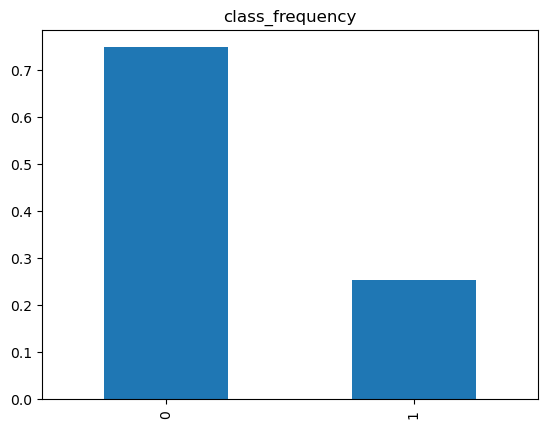

In [75]:
class_frequency = target_train.value_counts(normalize = True)
print(class_frequency)
class_frequency.plot(kind='bar', title= 'class_frequency')

#### Дисбаланс классов значительный, надо учесть это при обучении моделей. будем использовать метод взвешивания классов

### Для решения задачи исследуем три модели: Решающее дерево, случайный лес и логистическая регрессия, обучим и оценим их качество методом кроссвалидации.

#### Модель логистической регрессии

In [76]:
best_model_lr = None
best_final_score_lr = 0
best_max_iter = 0
penaltys = ['l1', 'l2'] 
for penaltys in penaltys:
    for iterations in (100, 1101, 100):
        model_lr = LogisticRegression(random_state=12345, solver='liblinear', max_iter=iterations, penalty=penaltys, class_weight='balanced')
        scores = cross_val_score(model_lr, features_train, target_train, scoring = 'recall', cv=5)
        final_score_lr = pd.Series(scores).mean()
        if final_score_lr > best_final_score_lr:
            best_model_lr = model_lr
            best_final_score_lr =  final_score_lr
            best_max_iter = iterations
            best_penaltys = penaltys
f'Средняя оценка качества лучшей модели: {best_final_score_lr}, max_iter: {best_max_iter}, penalty: {best_penaltys} '



'Средняя оценка качества лучшей модели: 0.4697567691601652, max_iter: 100, penalty: l2 '

#### Модель решающий дерево. Попробуем подобрать наилучшую глубину дерева

In [77]:
best_model_tree = None
best_final_score_tr = 0
best_depth_tree = 0
best_min_samples_leaf = 0
for depth in range (1,10):
    for leaf in range (1,6):
        model_t = DecisionTreeClassifier(random_state=12345, max_depth=depth, min_samples_split=2, min_samples_leaf=leaf, 
                                         class_weight='balanced')
        scores = cross_val_score(model_t, features_train, target_train, scoring = 'recall', cv=5)
        final_score_tr = pd.Series(scores).mean()
        if final_score_tr > best_final_score_tr:
            best_model_tree = model_t
            best_final_score_tr = final_score_tr
            best_min_samples_leaf = leaf
            best_depth_tree = depth
f'Средняя оценка качества лучшей модели: {best_final_score_tr}, глубина дерева: {best_depth_tree}, min_samples_leaf: {best_min_samples_leaf}'

'Средняя оценка качества лучшей модели: 0.9229921982560807, глубина дерева: 1, min_samples_leaf: 1'

#### Модель случайный лес. 

In [78]:
best_model_forest = None
best_final_score_forest = 0
best_est = 0
for est in range (10,60,10):
    model_forest = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=1, class_weight='balanced')
    scores = cross_val_score(model_forest, features_train, target_train,  scoring = 'recall', cv=5)
    final_score_forest = pd.Series(scores).mean()
    if final_score_forest > best_final_score_forest:
        best_model_forest = model_forest
        best_final_score_forest = final_score_forest
        best_est = est
f'Средняя оценка качества лучшей модели: {best_final_score_forest},  число деревьев {best_est}' 

'Средняя оценка качества лучшей модели: 0.7222579164754473,  число деревьев 30'

#### Самые хорошие результаты показала модель решающего дерева. Протестируем ее на тестовой выборке, оценим следующие параметры полноты, т.к для нас важно выявить как можно больше отказов от брони, также F-1 меру, так как нам надо соблюсти и баланс с точностью определения (если мы у всех будем просить депозиты, количество броней может сократиться), а также auc-roc для сравнения со случайной моделью.

In [79]:
model = DecisionTreeClassifier(random_state=12345, max_depth=1, min_samples_split=2, min_samples_leaf=1, 
                               class_weight='balanced')
model.fit(features_train, target_train)
predictions_tree_test = model.predict(features_test)
f1_test = f1_score(target_test, predictions_tree_test)
recall_test = recall_score(target_test, predictions_tree_test)
probabilities_test = model.predict_proba(features_test)
probabilities_test = probabilities_test[:,1]
auc_roc_test = roc_auc_score(target_test, probabilities_test)
f'Полнота тестовой выборки: {recall_test}, F1_мера тестовой выборки: {f1_test}, AUC-ROC тестовой выборки:{auc_roc_test}'

'Полнота тестовой выборки: 0.9506286013619696, F1_мера тестовой выборки: 0.5259001666304426, AUC-ROC тестовой выборки:0.5955186750087008'

#### Сравним с константной моделью

In [80]:
model_const = DummyClassifier(strategy="constant", constant=1)
model_const.fit(features_train, target_train)
f1_score(target_test, model_const.predict(features_test))

0.477160532400175

### Оценим прибыль, которую принесет внедрение модели 

####  Добавим столбец с предсказаниями в df_test

In [81]:
df_test['predictions'] = predictions_tree_test
df_test.head()

,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights,price_night,clean_room,price_night_coefficient,revenue,predictions
0,1,74,2017,January,1,1,1,0,2,0,...,0,Transient,0,0,1,1000,400,1000.0,-1400.0,1
1,1,62,2017,January,1,1,2,2,2,0,...,0,Transient,0,1,4,1000,400,1000.0,-1400.0,1
2,1,71,2017,January,1,1,2,2,1,0,...,0,Transient,0,1,4,1000,400,1000.0,-1400.0,1
3,1,172,2017,January,1,1,2,5,2,0,...,0,Transient,0,0,7,1000,400,1000.0,-1400.0,1
4,1,52,2017,January,1,1,2,5,1,0,...,0,Transient,0,0,7,1000,400,1000.0,-1400.0,1


#### Напишем функцию для расчета прибыли при внедрении модели. 
Логика расчета:
prediction=0 target=1 внедрение модели не повлияло на расчет ранее посчитанной прибыли 
prediction=0 target=0 внедрение модели не повлияло внедрение модели не повлияло на расчет ранее посчитанной прибыли  
prediction=1 target=1 внедрение модели повлияло на расчет ранее посчитанной прибыли (тут убыток меньше на величину депозита)
prediction=1 target=0 внедрение модели не повлияло на расчет ранее посчитанной прибыли 

In [82]:
def revenue_depozit(row):
    if (row['is_canceled'] + row['predictions']) == 2:
        return DEPOSIT_PROCENT*(row['price_night_coefficient'] + row['clean_room']) - (row['price_night_coefficient'] 
                                                                                         + row['clean_room'])
    else:
        return row['revenue']

In [83]:
df_test['revenue_depozit'] = df_test.apply(revenue_depozit, axis=1)
df_test.head()
revenue_after_deposit = df_test['revenue_depozit'].sum()
print('Прибыль за период с января по август 2017 года после внедрения депозита:', revenue_after_deposit)

Прибыль за период с января по август 2017 года после внедрения депозита: 42422318.0


#### Считаем чистую прибыли от внедрения модели и системы депозитов за вычетом расходов на разработку за период с января по август 2017 года. Чтобы приблизительно оценить годовую прибыль revenue разделим на 8 и умножим на 12

In [84]:
revenue = revenue_after_deposit - revenue_befor_depozit - BUDGET
revenue_year = revenue/8*12
print('Чистая прибыль за период с января по август 2017 года после внедрения депозита:', revenue)
print('Оценочная прибыль за год:', revenue_year)

Чистая прибыль за период с января по август 2017 года после внедрения депозита: 7480448.0
Оценочная прибыль за год: 11220672.0


#### При разработке оценивались 3 модели:  линейная регрессия, случайный лес и решающее дерево. Самые хорошие результаты при кросс валидации показала модель решающего дерева при глубине = 1 и min_samples_split=2, min_samples_leaf=1. Эта модель была протестирована на тестовой выборке - получили следующие показатели ('Полнота тестовой выборки: 0.9506286013619696, F1_мера тестовой выборки: 0.5259001666304426, AUC-ROC тестовой выборки:0.5955186750087008'). Проверили модель на адекватность при сравнии с постоянной моделью, показатели нашей модели выше, можно считать ее адекватной. Была посчитана чистая прибыль от внедрения модели за 8 месяцев 2017 года, она составила - 7480448.0 руб, т.е. уже за 8 месяцев модель покрывает расходы на разработку. Оценили прибыль за год  - это около 11220672.0.



## Шаг 5. Выявите признаки ненадежного клиента

### Посмотрим каких клиентов модель определила как ненадежных и они действительно отменили бронь

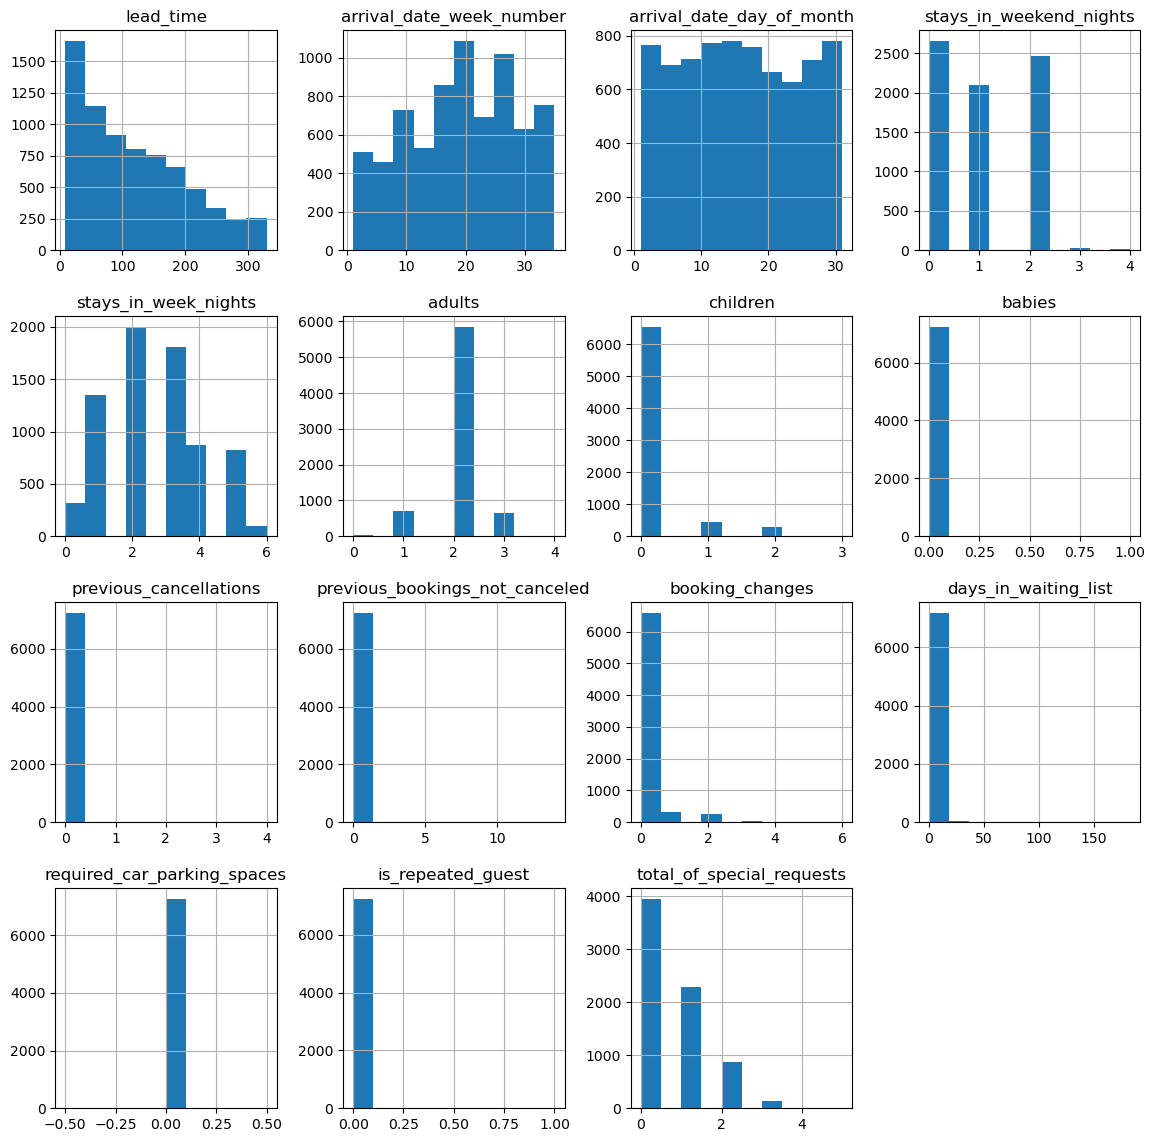

In [85]:
df_test.query('is_canceled == 1 and predictions == 1').hist(['lead_time', 'arrival_date_week_number', 'arrival_date_day_of_month', 'stays_in_weekend_nights', 
           'stays_in_week_nights', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled',
           'booking_changes', 'days_in_waiting_list','required_car_parking_spaces', 'is_repeated_guest', 'total_of_special_requests'], figsize=(14, 14));

Из предварительного просмотра гистограмм можем сразу отметить, что в категорию ненадежных клиентов попадают:
- двое взрослых без детей и младенцев
- лица, которые не вносили изменения в свои заказы
- лица, которые не запрашивали парковочного места
- лица, которые не запрашивали никаких дополнительных услуг

 ### Теперь рассмотрим признаки с типом 'object'

BB    0.702989
SC    0.219865
HB    0.076181
FB    0.000964
Name: meal, dtype: float64


<AxesSubplot:title={'center':'meal'}>

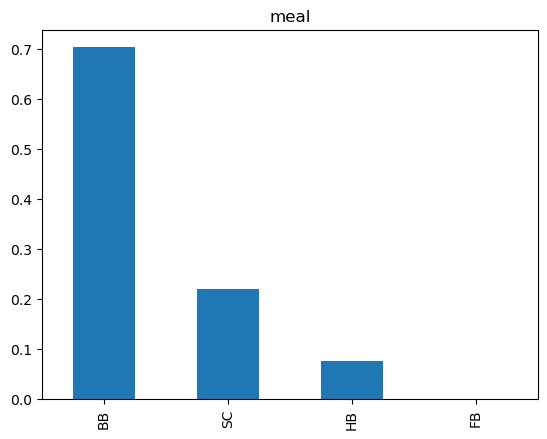

In [86]:
meal = df_test. query('is_canceled == 1 and predictions == 1')['meal'].value_counts(normalize = True)
print(meal)
meal.plot(kind='bar', title= 'meal')

#### Чаще отказываются от брони, те кто заказывает только завтраки

TA/TO        0.934564
Direct       0.050833
Corporate    0.013363
GDS          0.001240
Name: distribution_channel, dtype: float64


<AxesSubplot:title={'center':'distribution_channel'}>

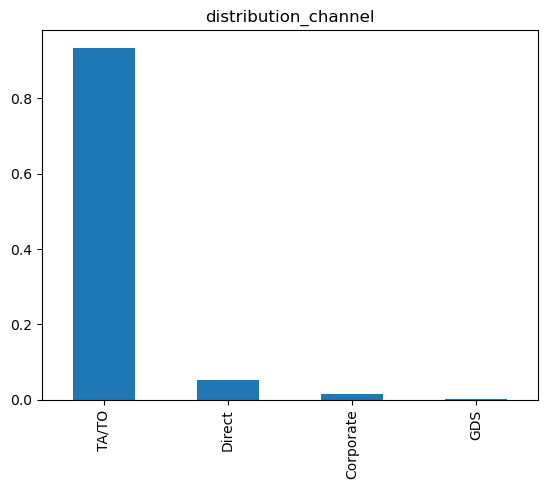

In [87]:
distribution_channel = df_test. query('is_canceled == 1 and predictions == 1')['distribution_channel'].value_counts(normalize = True)
print(distribution_channel)
distribution_channel.plot(kind='bar', title= 'distribution_channel')

#### Чаще отказываются от брони, те кто использует канал дистрибуции TA/TO 

A    0.644304
D    0.236947
E    0.063232
F    0.020664
G    0.014189
C    0.011021
B    0.009643
Name: reserved_room_type, dtype: float64


<AxesSubplot:title={'center':'reserved_room_type'}>

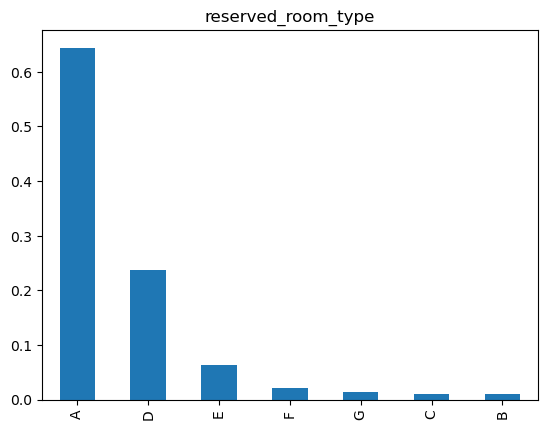

In [88]:
reserved_room_type = df_test. query('is_canceled == 1 and predictions == 1')['reserved_room_type'].value_counts(normalize = True)
print(reserved_room_type)
reserved_room_type.plot(kind='bar', title= 'reserved_room_type')

#### Чаще отказываются от брони, те кто бронирует номер категории А

Transient          0.961703
Transient-Party    0.032098
Contract           0.005510
Group              0.000689
Name: customer_type, dtype: float64


<AxesSubplot:title={'center':'customer_type'}>

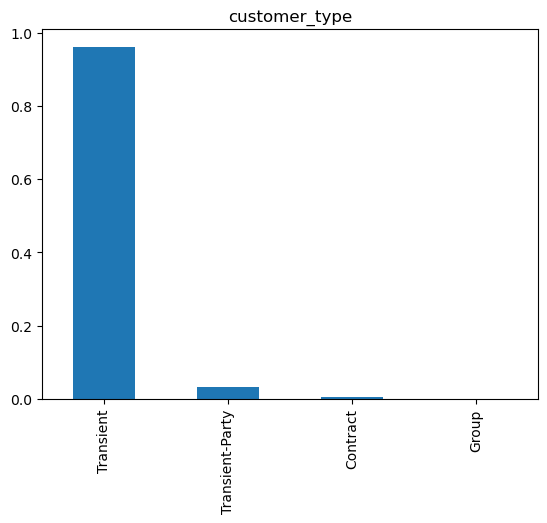

In [89]:
customer_type = df_test. query('is_canceled == 1 and predictions == 1')['customer_type'].value_counts(normalize = True)
print(customer_type)
customer_type.plot(kind='bar', title= 'customer_type')

#### Чаще отказываются от брони, у тех кого брони не связаны с договором или групповым заездом.

#### Таким образом признаками ненадежного клиента являются:
- двое взрослых без детей и младенцев
- лица, которые не вносили изменения в свои заказы
- лица, которые не запрашивали парковочного места
- лица, которые не запрашивали никаких дополнительных услуг
- лица, которые заказывают только завтраки
- лица, которые использует канал дистрибуции TA/TO 
- лица, которые бронирует номер категории А
- лица, у которых брони не связаны с договором или групповым заездом.

# Итоговый вывод:
1. Открыв файл и ознакомившись с общей информацией по бронированию увидели, что пропусков в данных нет, явных дубликатов не обнаружили, что отказов от брони достаточно много (больше половины тех, кто в итоге воспользовался услугами отеля). Прослеживается зависимость между количеством подтверждённых заказов и повторным бронированием. Также есть коллинеарные признаки total_nights и stays_in_weekend_nights и stays_in_week_nights. 
2. Проведя предобработку и исследовательский анализ данных сделали следующее:
- удалили столбец с id, как несущественный
- удалили большое количество дубликатов
- в ряде столбцов удалили лишние пробелы
- в ряде столбцов убрали выбросы и анамалии
- в столбце babies изменили значения больше 1 на 1, чтобы у нас было только два значения 0- нет младенцев, 1 - есть младенцы.
- в столбце required_car_parking_spaces, также заменили данные > 1 на единицу, чтобы было только два значения 0- не нужно прковочное место и 1 - нужно парковочное место
3. Посчитали прибыль гостиницы за представленный период 2017 года (январь-август) ддо внедрения депозитов, она составила - 34541870.0 руб.
4. Исследовали три модели логистическую регрессию, решающее дерево и случайный лес. Для борьбы с дисбалансом классов использолвали метод взвешивания классов, определяли качество модели методом кросс-валидации и выбирали лучшую.Самые хорошие результаты при кросс валидации показала модель решающего дерева при глубине = 1 и min_samples_split=2, min_samples_leaf=1 . Эта модель была протестирована на тестовой выборке - получили следующие показатели  (Полнота тестовой выборки: 0.9506286013619696, F1_мера тестовой выборки: 0.5259001666304426, AUC-ROC тестовой выборки:0.5955186750087008). Проверили модель на адекватность при сравнии с постоянной моделью, показатели нашей модели выше, можно считать ее адекватной. Была посчитана чистая прибыль от внедрения модели за 8 месяцев 2017 года, она составила - 7480448.0 руб, т.е. уже за 8 месяцев модель покрывает расходы на разработку. Оценили прибыль за год  - это около 11220672.0.0.
5. При анализе данных клиентов, которые модель определила как ненадежных, и по факту они отказались от брони, получили следующие признаки 'ненадежного клиента'.
- двое взрослых без детей и младенцев
- лица, которые не вносили изменения в свои заказы
- лица, которые не запрашивали парковочного места
- лица, которые не запрашивали никаких дополнительных услуг
- лица, которые заказывают только завтраки
- лица, которые использует канал дистрибуции TA/TO 
- лица, которые бронирует номер категории А
- лица, у которых брони не связаны с договором или групповым заездом

Таким образом можем рекомендовать внедрение модели, которая определяет отькажется ли клиент от брони или нет, и если определит, что откажется - предложит внести депозит.